In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN, SimpleDataSet
from model.Tokenizer import SimpleTokenizerV1
from model.TokenDrop import TokenDrop, TokenDropOdd, TokenDropEven
# from model.Transformers import Transformer
from environnement.gridWorld import gridWorld
from outil import *

In [ ]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads,
                 qkv_bias = False, device = 'cpu'):
        
        super().__init__()
        assert(d_out % num_heads == 0), "d_out should be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias).to(device)

        self.dropout = nn.Dropout(dropout).to(device)
        self.out_proj = nn.Linear(d_out, d_out).to(device)
        # If we want to see only past
        mask = torch.triu(torch.ones(context_length,context_length), diagonal=1).to(device)
        
        # if we want to see only future
        # mask = torch.tril(torch.ones(context_length,context_length), diagonal=-1).to(device)
        
        # If we want to see all the context
        # mask = torch.zeros(context_length, context_length, device=device)
        self.register_buffer('mask', mask)
        
    def forward(self,x: torch.Tensor):
        queries: torch.Tensor
        keys: torch.Tensor
        values: torch.Tensor
        b, num_tokens, d_in = x.shape # b, num_token, d_in

        # self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        # self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # Use one projection to get queries, keys and values
        # self.W_qkv(x) -> b, num_token, 3*d_out (is a tensor)
        # chunk(3, dim=-1) -> b, num_token, d_out we split the tensor in 3 parts
        queries, keys, values= self.W_qkv(x).chunk(3, dim=-1)
        
        # b, num_token, numheads, head_dim
        queries = queries.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        keys = keys.reshape(b,
                            num_tokens,
                            self.num_heads,
                            self.head_dim
                        ).transpose(1, 2)
        values = values.reshape(b,
                                num_tokens,
                                self.num_heads,
                                self.head_dim
                            ).transpose(1, 2)
        
        # b, num_heads, num_token, num_token
        attn_scores = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        
        attn_scores = attn_scores.masked_fill(
            self.mask[:num_tokens, :num_tokens].unsqueeze(0).unsqueeze(0).bool() == 1, 
            float('-inf')
        )

        attn_weights = nn.functional.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.einsum('bhqk, bhkd -> bhqd', 
                               attn_weights, 
                               values
                            ).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        
        return self.out_proj(context)
    
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        # TODO fct FFN we can remove or add some layers
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"] // 2, bias=cfg["qkv_bias"]),
            nn.GELU(),
            nn.Linear(cfg["emb_dim"] // 2, cfg["emb_dim"], bias=cfg["qkv_bias"])
        )
        
    def forward(self,x):
        return self.layers(x)
    

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.norm1 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            dropout = cfg["drop_rate"],
            num_heads = cfg["n_heads"],
            qkv_bias = cfg["qkv_bias"],
            device=cfg["device"]
        )
        self.ff = FeedForward(cfg).to(cfg["device"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        self.dropout = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)

        x = self.dropout(x)

        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        
        return x

class Transformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(cfg["device"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(cfg["device"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(cfg["device"])
        
        self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.norm = nn.LayerNorm(cfg["emb_dim"]).to(cfg["device"])
        
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["out_vocab_size"], bias=False).to(cfg["device"])
        self.tok_emb.weight = self.out_head.weight
        
        # self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
        # Special initialization for transformer projection layers
        # for pn, p in self.named_parameters():
        #     if pn.endswith('c_proj.weight'):
        #         # torch.nn.init.normal_(p,
        #         #                     mean=0.0,
        #         #                     std=0.02 / math.sqrt(2 * self.cfg["n_layers"]))
        
    def forward(self,x):
        b, seq_len = x.shape
        device = x.device
        
        tok_embeds = self.tok_emb(x)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.norm(x)
        logits = self.out_head(x)
        return logits



# Data

In [4]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

def get_data_without(env:env, tokenizer:SimpleTokenizerV1, acts:list[str] , n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    all_action = [element for element in all_action if element not in acts]
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


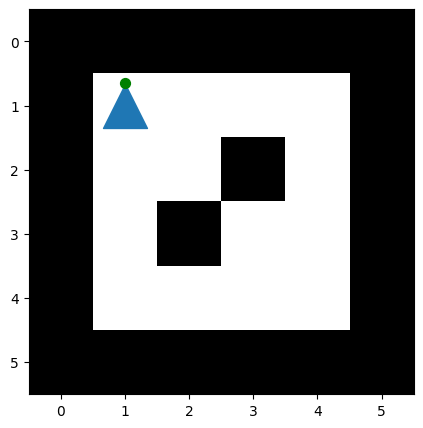

In [5]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Tokenizer

In [6]:
list_vocab = ['<pad>', '<mask>']
for act in env_test.get_actions():
    list_vocab.append(act)
for fb in env_test.get_outcomes():
    list_vocab.append(fb)    
tmp = create_dico_numerate_word(list_vocab)
tokenizer = SimpleTokenizerV1(vocab=tmp)
for key, value in tokenizer.int_to_str.items():
    print(f"{key}: {value}")

0: <pad>
1: <mask>
2: forward
3: turn_left
4: turn_right
5: feel_front
6: feel_left
7: feel_right
8: wall
9: empty


# X and Y

## Chaque séquence est complètement indépendante
### Res :
Spoil : au moins a partir de 500, > 95% d'acc (50 epoch) Attention on comptant les "turn"

In [7]:
data_brut_y=[]
context_length = 50 # must be even
for i in range(700):
    data_brut_y.append(get_data(env_test, tokenizer, n_episodes=context_length // 2))

data_y = torch.tensor(data_brut_y)
data_loader = DataLoader(data_y, batch_size=16, shuffle=True)


## Une grande séquence découper

In [8]:
data_brut = get_data(env_test, tokenizer, n_episodes=1000)
print(data_brut)
def decoup_seq(seq:list, size:int, overlap:int=1):
    """
    Decoupe une sequence en sous-sequence de taille size
    """
    return [seq[i:i+size] for i in range(0, len(seq) - size +1, overlap)]

data_decoup = decoup_seq(seq=data_brut, size=30, overlap=10)
print(data_decoup)
data_decoup = torch.tensor(data_decoup)
data_loader_decoup = DataLoader(data_decoup, batch_size=16, shuffle=True)

[3, 9, 6, 9, 5, 9, 3, 9, 7, 9, 2, 9, 3, 9, 3, 9, 3, 9, 3, 9, 4, 9, 5, 8, 6, 9, 2, 8, 7, 9, 4, 9, 3, 9, 5, 8, 4, 9, 3, 9, 3, 9, 2, 9, 4, 9, 6, 9, 6, 9, 7, 9, 4, 9, 3, 9, 7, 9, 7, 9, 4, 9, 5, 9, 6, 9, 3, 9, 2, 9, 7, 8, 7, 8, 3, 9, 6, 9, 7, 8, 5, 9, 5, 9, 2, 9, 6, 9, 7, 9, 6, 9, 5, 8, 5, 8, 2, 8, 2, 8, 6, 9, 4, 9, 7, 9, 4, 9, 3, 9, 6, 8, 2, 9, 7, 8, 7, 8, 2, 9, 5, 8, 2, 8, 7, 9, 5, 8, 7, 9, 7, 9, 5, 8, 2, 8, 4, 9, 3, 9, 3, 9, 5, 8, 7, 8, 3, 9, 3, 9, 6, 8, 4, 9, 4, 9, 7, 8, 4, 9, 7, 9, 5, 8, 7, 9, 4, 9, 3, 9, 3, 9, 4, 9, 2, 8, 5, 8, 4, 9, 2, 9, 5, 9, 3, 9, 3, 9, 4, 9, 7, 9, 6, 9, 2, 8, 3, 9, 5, 9, 2, 9, 6, 9, 7, 8, 3, 9, 6, 9, 5, 9, 4, 9, 6, 9, 2, 8, 4, 9, 6, 8, 2, 8, 2, 8, 2, 8, 2, 8, 6, 8, 5, 8, 2, 8, 7, 9, 6, 8, 3, 9, 7, 8, 3, 9, 5, 9, 6, 9, 7, 8, 4, 9, 2, 8, 7, 8, 7, 8, 6, 9, 3, 9, 5, 9, 5, 9, 7, 8, 4, 9, 4, 9, 5, 8, 6, 8, 7, 9, 5, 8, 2, 8, 5, 8, 7, 9, 5, 8, 2, 8, 7, 9, 6, 8, 2, 8, 7, 9, 7, 9, 3, 9, 4, 9, 2, 8, 4, 9, 3, 9, 5, 8, 2, 8, 6, 8, 6, 8, 3, 9, 2, 8, 2, 8, 3, 9, 3, 9, 5, 9, 5, 

data_y est alors notre Y. Pour obtenir notre X, nous utiliserons un token Dropen

Notre x est donc data_x. Maintenant nous voulons que notre model arrive à obvenir un représentation de la séquence pour réussir a compléter les 0.

# Multi tasks ?
On peut vouloir un encoder qui apprend a encoder pour deviner les actions, et un encoder qui apprends a deviner les observations.


In [9]:
data_set = SimpleDataSet(data_brut_y)

print("len data_set", data_set.__len__())
print("data_set 1", data_set[0])

tensor([[7, 9, 7,  ..., 9, 2, 9],
        [3, 9, 4,  ..., 9, 3, 9],
        [7, 8, 4,  ..., 9, 5, 8],
        ...,
        [4, 9, 7,  ..., 8, 5, 8],
        [2, 8, 2,  ..., 9, 7, 9],
        [3, 9, 4,  ..., 8, 2, 9]])
len data_set 50
data_set 1 tensor([7, 9, 7, 9, 4, 9, 3, 9, 5, 8, 3, 9, 2, 8, 5, 8, 3, 9, 5, 9, 6, 9, 2, 9,
        6, 9, 7, 8, 2, 9, 4, 9, 4, 9, 4, 9, 4, 9, 3, 9, 7, 9, 3, 9, 7, 8, 5, 9,
        2, 9])


In [10]:
def train(model, data_loader, optimizer, loss_fn, epoch, td:TokenDropOdd, device):
    
    list_loss = []
    list_loss_all = []
    model.train()
    for e in tqdm(range(epoch), desc="Epoch"):
        total_loss = 0
        for i, y in enumerate(tqdm(data_loader, desc="Batch")):
            x = td(y)
            x = x.to(device)
            y = y.to(device)
            
            logits = model(x)
            
            optimizer.zero_grad()
            loss = loss_fn(logits.flatten(0,1), y.flatten())
            list_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
        train_loss = total_loss / len(data_loader.dataset)
        list_loss_all.append(train_loss)
    return list_loss_all, list_loss


In [ ]:
cfg = {
    "vocab_size": len(tokenizer.int_to_str),
    "out_vocab_size": len(tokenizer.int_to_str),
    "emb_dim": 128,
    "context_length": context_length,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": True,
    "device": device
}

transformer_model = Transformer(cfg).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.encode("<pad>")).to(device)
optimizer = optim.AdamW(transformer_model.parameters(), lr=1e-3, weight_decay=1e-4)

td = TokenDropOdd(
    num_special=2,
    pad_token=tokenizer.encode("<mask>"),
    prob=0.25
)
loss, all_loss = train(
    model=transformer_model,
    data_loader=data_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epoch=100,
    td=td,
    device=device
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

loss [0.07521190515586308, 0.03909424049513681, 0.014970734332289015, 0.009856398680380412, 0.008475956310118948, 0.007175503362502371, 0.006759112988199507, 0.006020963910434927, 0.005574289209076337, 0.005175077617168427]
all_loss [2.154146671295166, 1.8538135290145874, 1.7673099040985107, 1.6713024377822876, 1.5941991806030273, 1.4860690832138062, 1.4138641357421875, 1.330859661102295, 1.252148151397705, 1.2454780340194702, 1.1886345148086548, 1.1912192106246948, 1.1511844396591187, 1.1582577228546143, 1.1314843893051147, 1.1470383405685425, 1.1321030855178833, 1.1284117698669434, 1.0990543365478516, 1.1223374605178833, 1.1415202617645264, 1.0887939929962158, 1.115471363067627, 1.0943706035614014, 1.1057021617889404, 1.1225568056106567, 1.0912015438079834, 1.1000523567199707, 1.0823771953582764, 1.067831039428711, 1.0753806829452515, 1.0640674829483032, 1.0618540048599243, 1.0740352869033813, 1.0464661121368408, 1.028698444366455, 1.0266385078430176, 1.003688097000122, 1.00962877273

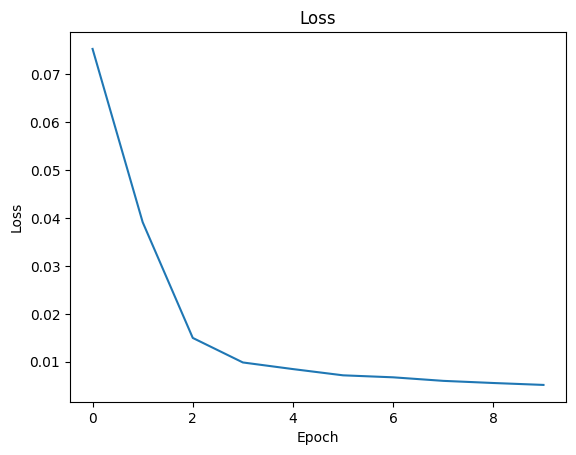

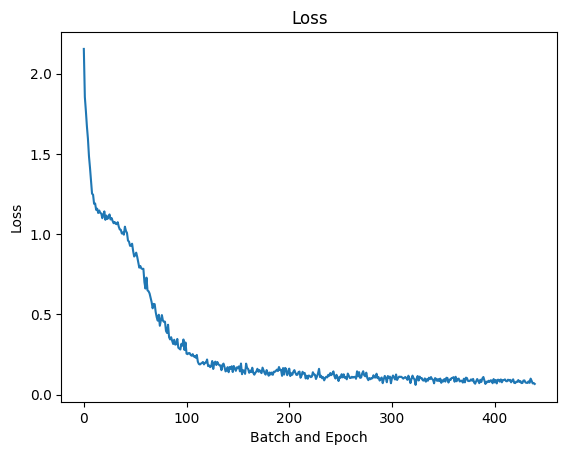

In [12]:
print("loss", loss)
print("all_loss", all_loss)

# plot
plt.plot(loss)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(all_loss)
plt.title("Loss")
plt.xlabel("Batch and Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
list_test = \
[5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 1, 8, 5, 7, 1, 8, 1, 7, 2, 8, 4, 8, 6, 7, 5, 8, 6, 7, 6, 7, 5, 8, 6, 7, 2, 8, 5, 7, 5, 7, 3, 8, 6, 7, 5, 8, 1, 0]


list_test = [i + 1 for i in list_test]
print("list_test", list_test)
print("len list_test", len(list_test))
print('context_length', context_length)

# Pass to model and generate the output
x = torch.tensor(list_test).unsqueeze(0)
x = x.to(device)
print("x", x)
logits = transformer_model(x)
# Get the predicted token
predicted_token = torch.argmax(logits, dim=-1)
print("predicted_token", predicted_token)
print("predicted_token shape", predicted_token.shape)
# decode the predicted token
predicted_token = predicted_token.squeeze(0).tolist()
print("predicted_token", predicted_token)
# decode the predicted token
predicted_token = tokenizer.decode(predicted_token)
print("predicted_token", predicted_token)




list_test [6, 9, 6, 9, 6, 9, 6, 9, 6, 9, 6, 9, 2, 9, 6, 8, 2, 9, 2, 8, 3, 9, 5, 9, 7, 8, 6, 9, 7, 8, 7, 8, 6, 9, 7, 8, 3, 9, 6, 8, 6, 8, 4, 9, 7, 8, 6, 9, 2, 1]
len list_test 50
context_length 50
x tensor([[6, 9, 6, 9, 6, 9, 6, 9, 6, 9, 6, 9, 2, 9, 6, 8, 2, 9, 2, 8, 3, 9, 5, 9,
         7, 8, 6, 9, 7, 8, 7, 8, 6, 9, 7, 8, 3, 9, 6, 8, 6, 8, 4, 9, 7, 8, 6, 9,
         2, 1]])
logits tensor([[[-7.4811e-01,  6.2484e-01, -1.4457e+00, -3.7934e+00,  1.8759e+00,
          -4.2730e+00,  1.2531e+01, -1.1448e+00, -1.3461e+00, -8.5455e-01],
         [-2.0175e+00, -2.9542e+00, -2.9224e+00, -1.1496e+00, -2.8593e+00,
          -2.3295e-01, -2.6549e+00, -4.9696e+00,  3.0149e+00,  8.8252e+00],
         [-1.1094e+00, -9.5614e-01,  1.3176e+00, -4.0046e+00, -1.0215e+00,
           2.6275e+00,  1.1669e+01, -3.3328e+00, -3.1419e+00, -6.4147e-01],
         [-2.3148e+00, -2.7003e+00, -1.9331e+00, -6.4792e-01, -1.8705e+00,
          -1.0274e+00, -4.6269e+00, -4.8531e+00,  2.9472e+00,  8.8843e+00],
         [-1

In [14]:
# env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 0, 0, 1, 0, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

# action = []
# outcome = []
# all_seq = []
# list_act_to_make = ['turn_right', 'forward', 'turn_left', 'forward', 'feel_right']

# for act in list_act_to_make:
#     action.append(act)
#     outcome.append(env_test_manu.outcome(action[-1]))
#     env_test_manu.save_world(path='imgToGif')
#     all_seq += tokenizer.encode([action[-1], outcome[-1]])

# print("Action : ", action)
# print("Outcome : ", outcome)
# print("all_seq : ", all_seq)

# # We add one action exemple feel left


In [24]:
transformer_model.eval()
prompt = tokenizer.encode(
['feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall','feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty']
)

print("prompt len", len(prompt) + 2)
print("context length", context_length)


# Pass to model and generate the output
x = torch.tensor(prompt + tokenizer.encode(['feel_front', '<pad>'])).unsqueeze(0)
print(x.shape)
x = x.to(device)
print("x", x)
logits = transformer_model(x)
predicted_token = torch.argmax(logits, dim=-1)
predicted_token = predicted_token.squeeze(0).tolist()
predicted_token = tokenizer.decode(predicted_token)
print("predicted_token fell_front", predicted_token)

x = torch.tensor(prompt + tokenizer.encode(['feel_left', '<pad>'])).unsqueeze(0)
x = x.to(device)
print("x", x)
logits = transformer_model(x)
predicted_token = torch.argmax(logits, dim=-1)
predicted_token = predicted_token.squeeze(0).tolist()
predicted_token = tokenizer.decode(predicted_token)
print("predicted_token feel_left", predicted_token)

x = torch.tensor(prompt + tokenizer.encode(['feel_right', '<pad>'])).unsqueeze(0)
x = x.to(device)
print("x", x)
logits = transformer_model(x)
predicted_token = torch.argmax(logits, dim=-1)
predicted_token = predicted_token.squeeze(0).tolist()
predicted_token = tokenizer.decode(predicted_token)
print("predicted_token feel_right", predicted_token)

prompt len 50
context length 50
torch.Size([1, 50])
x tensor([[5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8,
         5, 8, 5, 8, 5, 8, 5, 8, 4, 9, 4, 9, 5, 9, 4, 9, 5, 8, 4, 9, 4, 9, 4, 9,
         5, 0]])
predicted_token fell_front ['feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty', 'turn_right', 'empty', 'feel_front', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'wall']
x tensor([[5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8,
         5, 8, 5, 8, 5, 8, 5, 8, 4, 9, 4, 9, 5, 9, 4, 9, 5, 8, 4, 9, 4, 9, 4, 9,
         6, 0]])
p

In [ ]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x = []
data_test_y = []
data_infos = []
for i in range(20000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [0])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 8:
        count_8 += 1
    elif i == 7:
        count_7 += 1
print(f"count_8 {tokenizer.decode(8)}", count_8)
print(f"count_7 {tokenizer.decode(7)}", count_7)

print("data_infos", data_infos[0])
print("x ", data_test_x[0])
print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 empty 10261
count_7 wall 9739
data_infos {'sequence': [1, 7, 6, 8, 3, 8, 6, 8, 2, 8, 4, 7, 4, 7, 4, 7, 4, 7, 1, 7, 6, 8, 6, 8, 6, 8, 1, 7, 4, 7, 6, 8, 5, 7, 5, 7, 5, 7, 1, 7], 'coo': (1, 1), 'theta': 0, 'last_act': 'forward', 'last_feedback': 'wall', 'info_in_sequence': True, 'feel_front': 'wall', 'feel_left': 'wall', 'feel_right': 'empty'}
x  [1, 7, 6, 8, 3, 8, 6, 8, 2, 8, 4, 7, 4, 7, 4, 7, 4, 7, 1, 7, 6, 8, 6, 8, 6, 8, 1, 7, 4, 7, 6, 8, 5, 7, 5, 7, 5, 7, 1, 0]
y  7


In [ ]:
for key, value in data_infos[56].items():
    print(f"{key}: {value}")


sequence: [6, 8, 6, 8, 1, 7, 2, 8, 5, 8, 1, 7, 1, 7, 6, 7, 4, 7, 6, 7, 5, 8, 4, 7, 1, 7, 2, 8, 4, 8, 5, 8, 1, 8, 6, 7, 5, 7, 5, 7]
coo: (2, 4)
theta: 1
last_act: feel_left
last_feedback: wall
info_in_sequence: True
feel_front: empty
feel_left: wall
feel_right: wall


In [ ]:
length = max(len(xi) for xi in data_test_x)
data_test_x_tensor = torch.zeros((len(data_test_x), length), dtype=torch.long)
for i, xi in enumerate(data_test_x):
    data_test_x_tensor[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor = torch.tensor(data_test_y, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor, data_infos), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

tensor([[1, 7, 6, 8, 3, 8, 6, 8, 2, 8, 4, 7, 4, 7, 4, 7, 4, 7, 1, 7, 6, 8, 6, 8,
         6, 8, 1, 7, 4, 7, 6, 8, 5, 7, 5, 7, 5, 7, 1, 0]])
tensor([7])
sequence: [tensor([1]), tensor([7]), tensor([6]), tensor([8]), tensor([3]), tensor([8]), tensor([6]), tensor([8]), tensor([2]), tensor([8]), tensor([4]), tensor([7]), tensor([4]), tensor([7]), tensor([4]), tensor([7]), tensor([4]), tensor([7]), tensor([1]), tensor([7]), tensor([6]), tensor([8]), tensor([6]), tensor([8]), tensor([6]), tensor([8]), tensor([1]), tensor([7]), tensor([4]), tensor([7]), tensor([6]), tensor([8]), tensor([5]), tensor([7]), tensor([5]), tensor([7]), tensor([5]), tensor([7]), tensor([1]), tensor([7])]
coo: [tensor([1]), tensor([1])]
theta: tensor([0])
last_act: ['forward']
last_feedback: ['wall']
info_in_sequence: tensor([True])
feel_front: ['wall']
feel_left: ['wall']
feel_right: ['empty']


In [ ]:
model_fb.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test),
    
})

# data_frame_seq = data_frame_seq.astype({
#     "seq": "object",
#     "prediction": "U20",
#     "reality": "object",
#     "probability": "object",
#     "good_prediction": "bool",
#     "info_in_seq": "bool",
#     "info_feel_left": "bool",
#     "info_feel_front": "bool",
#     "info_feel_right": "bool",
#     "coo_xy": "object",
#     "theta": "int64"
# })

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target = target.to(device)
        h = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        cell = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
        output, h, cell = model_fb(input, h, cell)
        
        arrays, x, y, theta = process_sequence(tokenizer.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == target).item()
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(tokenizer.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(tokenizer.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            tokenizer.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 20000}")

0it [00:00, ?it/s]

In [ ]:
# keep only row with good_prediction = True
data_frame_seq_success = data_frame_seq.loc[data_frame_seq["good_prediction"]]

# Résultat

0.96 % d'accuracy  

data test est constituer de 82% sequence dont l'information/feedback demandé a été vue  

Sur la partie où l’information n'est pas dans la séquence, l'accuracy tombe à 83%  

Sur la partie où l’information est dans la séquence, l'accuracy monte à 99%

## Not same environment
Quand il n'y a pas le même environment (autre grille) entre le train et le teste, 
acc = 83%
  
Si nous prenons que les seq avec infos alors on passe à 97% 

## Big context
0.97 % 
92% on une séquence avec une infos
sinon même stats

# Embeding

In [ ]:
model_fb.eval()
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size).to(device)
print("hidden_in", hidden_in.shape)
print("mem_in", mem_in.shape)
all_hidden = []
all_mem = []
all_output_1 = []
all_output_2 = []

# for x, y, info in zip(data_test_x, data_test_y, data_infos):
#     input_seq = torch.tensor(x).to(device)
#     output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
#     all_hidden.append(hidden_out[-1])
#     all_mem.append(mem_out[-1])
#     all_output_1.append(output[-1])
#     all_output_2.append(output[29])

# keep only data_frame_seq(data frame) with feel_left, feel_front, feel_right
data_infos_success = data_frame_seq.loc[
    # (data_frame_seq["info_feel_left"]) & 
    # (data_frame_seq["info_feel_front"]) & 
    # (data_frame_seq["info_feel_right"]) &
    # (data_frame_seq["good_prediction"])
    (data_frame_seq["info_in_seq"])
]
print("data_infos_success", len(data_infos_success))

# data_infos_sucess = [d for d in data_infos if all(d["feel_left", "feel_front", "feel_right"])]
for sequence in data_infos_success["seq"]:
    sequence = eval(sequence)
    input_seq = torch.tensor(sequence).to(device)
    output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))
    all_hidden.append(hidden_out[-1])
    all_mem.append(mem_out[-1])
    all_output_1.append(output[-1])
    all_output_2.append(output[-3])


# print("shape output", all_output_1[0].shape)

hidden_in torch.Size([4, 1, 256])
mem_in torch.Size([4, 1, 256])
data_infos_success 10133


In [ ]:
print(tokenizer.encode(["feel_front", "feel_left", "feel_right"]))

[4, 5, 6]


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_20214/1474131097.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_coo))
/tmp/ipykernel_20214/1474131097.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
/tmp/ipykernel

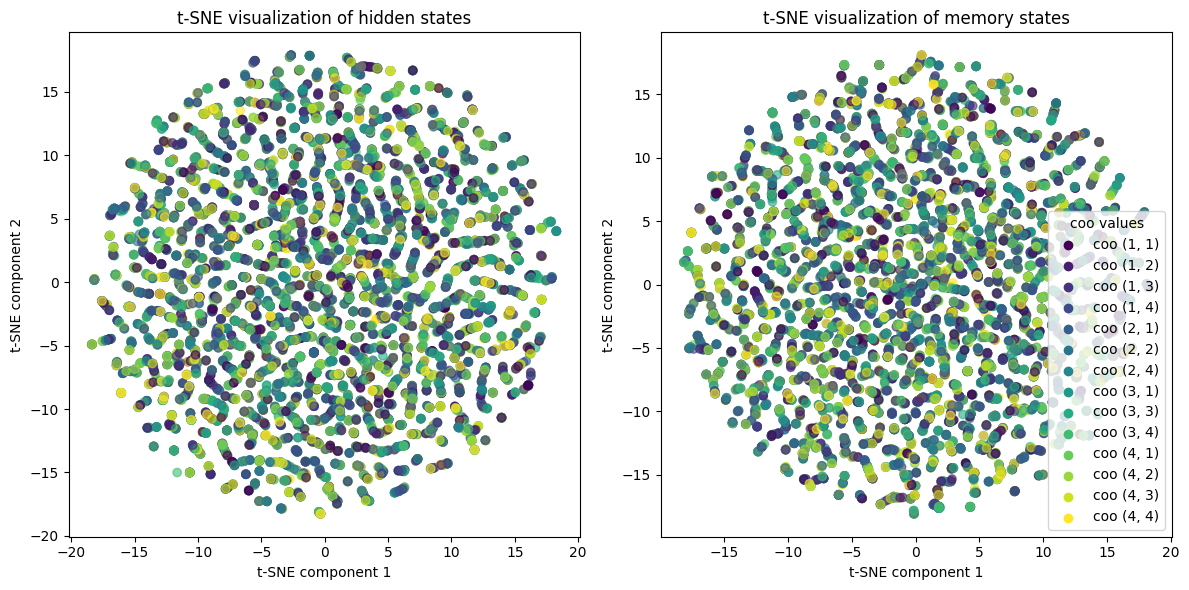

all_output_stack (10133, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10133, 2)


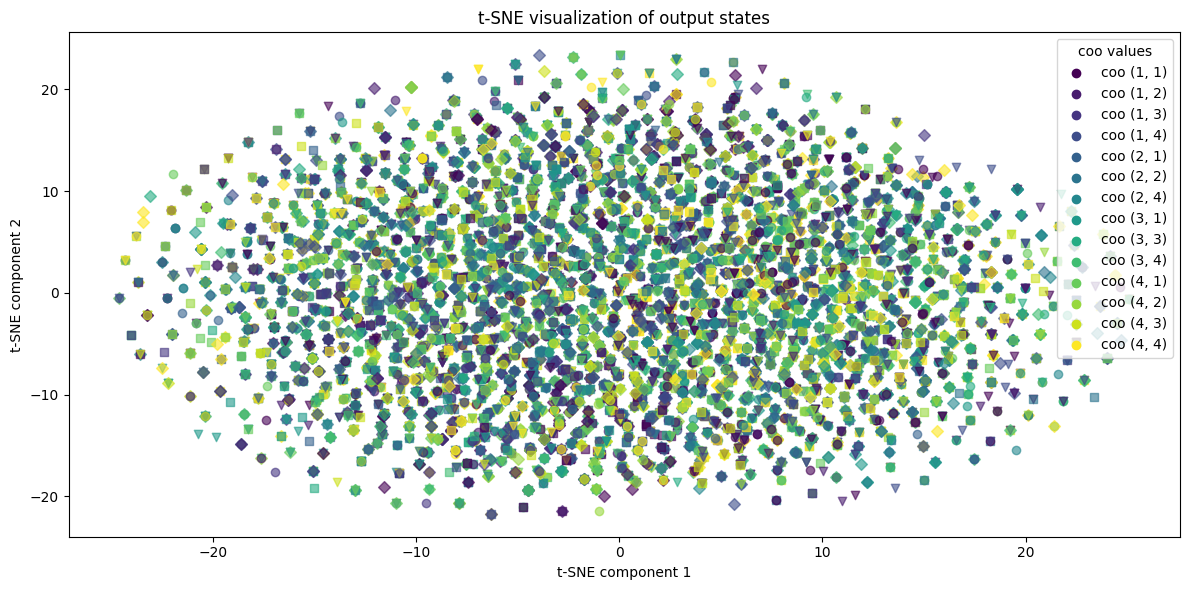

all_output_stack (10133, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10133, 2)


/tmp/ipykernel_20214/1474131097.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)


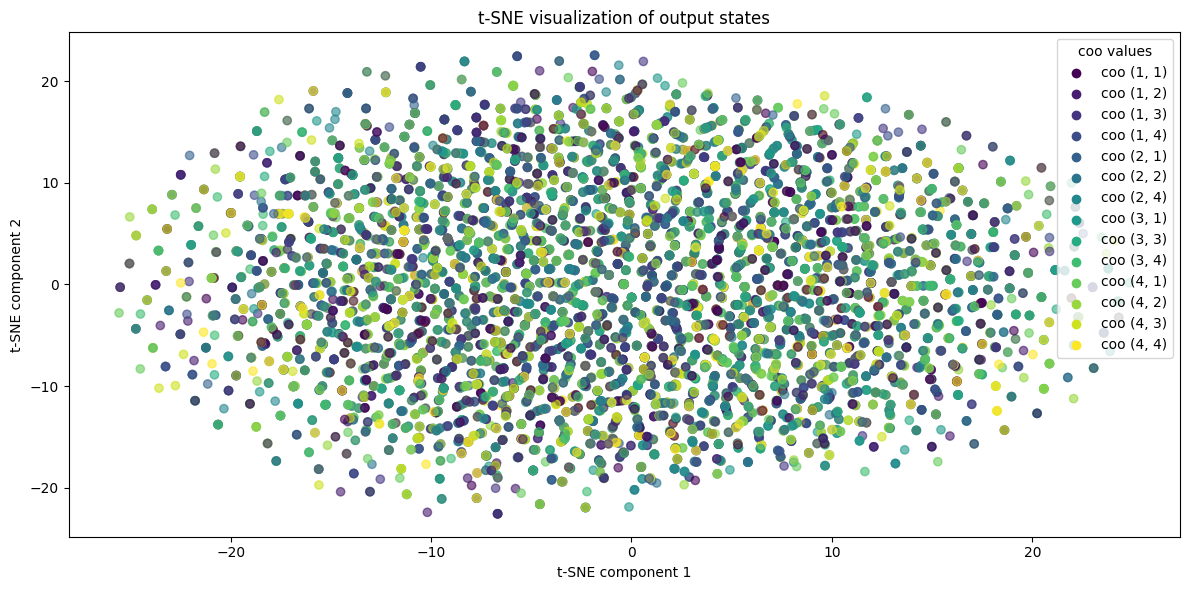

In [ ]:
import seaborn as sns
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

coo_info = data_infos_success["coo_xy"].tolist()

unique_coo = np.unique(coo_info)
color_map = plt.cm.get_cmap('viridis', len(unique_coo))
coo_colors = [color_map(unique_coo.tolist().index(str(coo))) for coo in coo_info]

theta_info = data_infos_success["theta"].tolist()

unique_theta = np.unique(theta_info)
# Attribuer une former pour chaque valeur unique de theta
markers_list = ['o', 's', 'D', 'v', '^', '<', '>', 'P', 'X', '*']
markers_map = {theta: markers_list[i % len(markers_list)] for i, theta in enumerate(unique_theta)}
theta_markers = [markers_map[theta] for theta in theta_info]


plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')

# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')

plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[coo_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=coo_colors, cmap='rocket', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_coo, color_map(np.arange(len(unique_coo)))):
    plt.scatter([], [], c=[color], label=f'coo {coo}')
plt.legend(title='coo values')
plt.tight_layout()
plt.show()
plt.close()

all_hidden torch.Size([10133, 256])
all_mem torch.Size([10133, 256])
all_hidden (10133, 256)
all_mem (10133, 256)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_hidden_emb (10133, 2)
all_mem_emb (10133, 2)
feel_info ['wa|wa|em', 'em|em|wa', 'wa|em|em', 'wa|em|wa', 'wa|em|wa', 'wa|wa|em', 'em|wa|wa', 'em|wa|em', 'wa|em|em', 'em|wa|em', 'em|em|wa', 'wa|em|em', 'wa|wa|em', 'wa|wa|em', 'em|wa|em', 'wa|em|wa', 'em|wa|wa', 'wa|em|wa', 'wa|wa|em', 'em|wa|em', 'em|wa|em', 'em|wa|wa', 'em|wa|wa', 'em|wa|em', 'em|wa|em', 'em|wa|em', 'wa|wa|em', 'em|em|wa', 'wa|wa|em', 'wa|em|em', 'em|wa|wa', 'em|wa|wa', 'wa|wa|em', 'wa|em|em', 'em|wa|wa', 'em|wa|em', 'em|wa|em', 'em|wa|wa', 'em|wa|wa', 'em|wa|wa', 'wa|em|em', 'em|wa|wa', 'wa|wa|em', 'wa|wa|em', 'wa|em|em', 'em|wa|em', 'em|em|wa', 'em|em|wa', 'em|wa|em', 'em|wa|em', 'wa|em|wa', 'em|wa|wa', 'wa|wa|em', 'wa|wa|em', 'wa|em|em', 'wa|wa|em', 'em|em|wa', 'em|wa|wa', 'wa|em|wa', 'em|em|em', 'em|wa|em', 'em|wa|wa', 'em|wa|wa', 'wa|em|em', 'em|wa|em', 'em|wa|wa', 'em|wa|em', 'wa|em|wa', 'em|wa|wa', 'em|wa|wa', 'wa|wa|em', 'wa|wa|em', 'wa|wa|em', 'wa|em|wa', 'em|wa|em', 'em|em|em', 'wa|wa|em', 'em|wa|wa', 'em|

/tmp/ipykernel_20214/1109148377.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_20214/1109148377.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_20214/1109148377.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


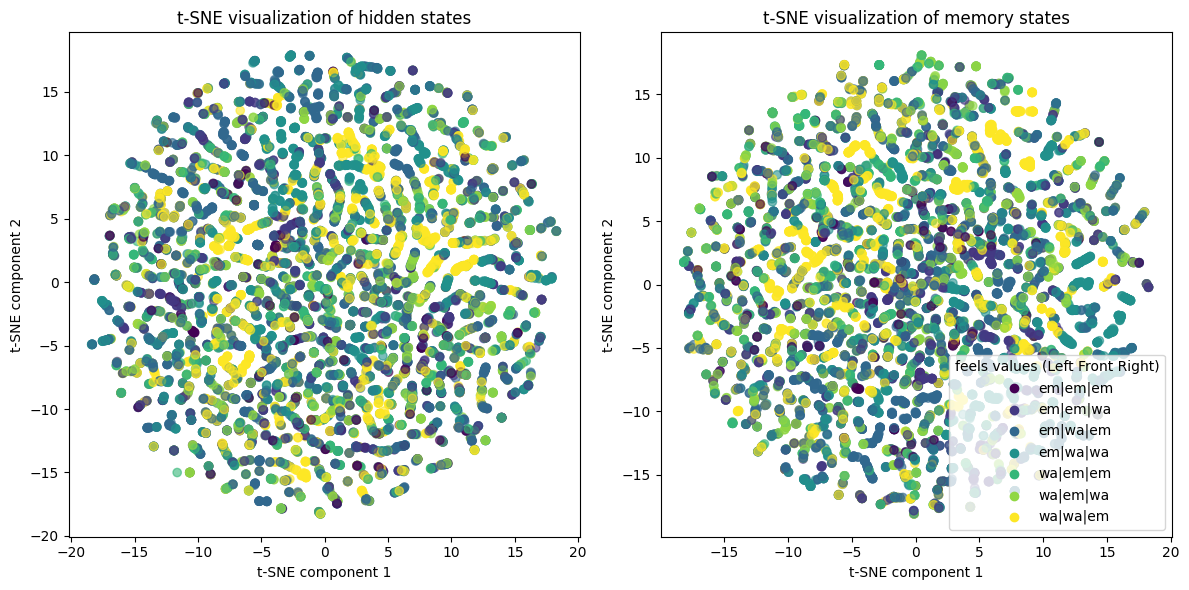

all_output_stack (10133, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10133, 2)


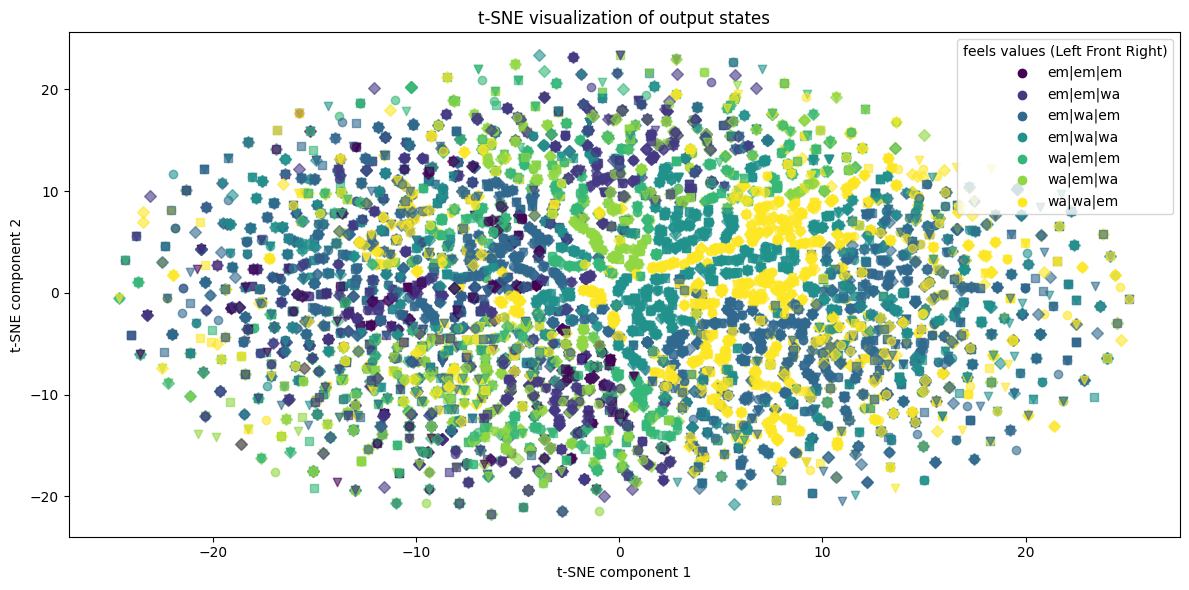

all_output_stack (10133, 512)


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


all_output_emb (10133, 2)


/tmp/ipykernel_20214/1109148377.py:72: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)


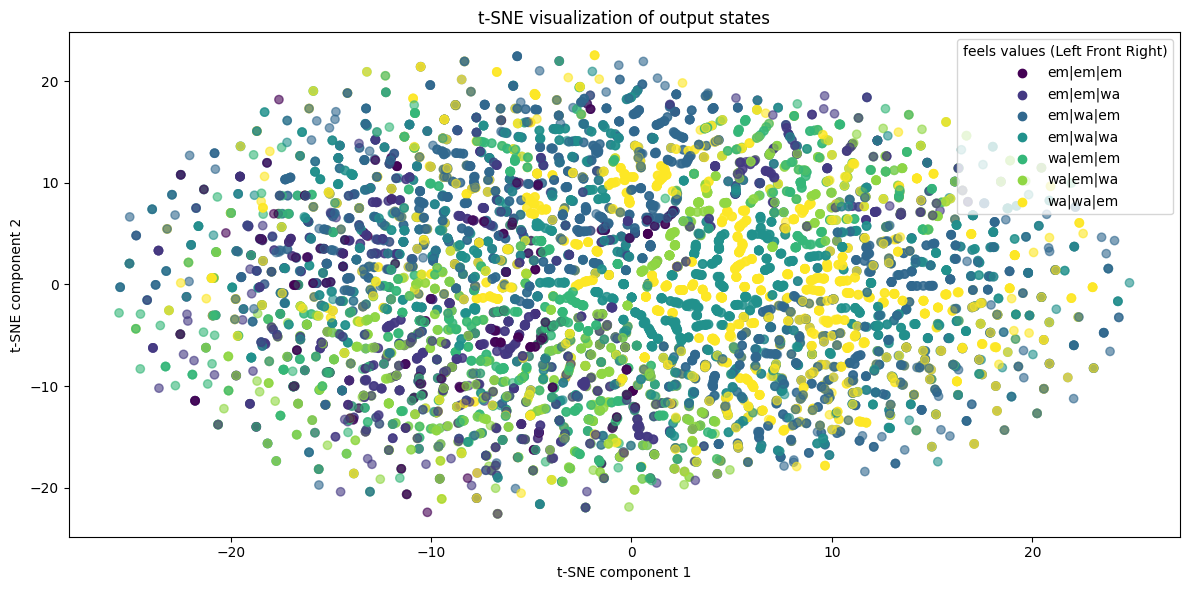

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
print("all_hidden", all_hidden_stack.shape)
print("all_mem", all_mem_stack.shape)
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
print("all_hidden_emb", all_hidden_emb.shape)
print("all_mem_emb", all_mem_emb.shape)

feel_info = [str(info[0][0:2]) + '|' + str(info[1][0:2]) + '|' + str(info[2][0:2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]

print("feel_info", feel_info)
unique_feel = np.unique(feel_info)
print("unique_feel", unique_feel)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]
plt.figure(figsize=(12, 6))
# Plot pour all_hidden_emb
plt.subplot(1, 2, 1)
plt.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of hidden states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Plot pour all_mem_emb
plt.subplot(1, 2, 2)
plt.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of memory states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_1)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
for i in range(len(all_output_emb)):
    plt.scatter(all_output_emb[i, 0], all_output_emb[i, 1], c=[feel_colors[i]], marker=theta_markers[i], alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=300)

all_output_stack = torch.stack(all_output_2)
all_output_stack = all_output_stack.detach().cpu().numpy()
print("all_output_stack", all_output_stack.shape)
all_output_emb = tsne.fit_transform(all_output_stack)
print("all_output_emb", all_output_emb.shape)
plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=feel_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for feel, color in zip(unique_feel, color_map(np.arange(len(unique_feel)))):
    plt.scatter([], [], c=[color], label=f'{feel}')
plt.legend(title='feels values (Left Front Right)')
plt.tight_layout()
plt.show()


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


act_pred ['forward | wall', 'forward | empty', 'feel_right | empty', 'feel_right | wall', 'feel_right | wall', 'forward | empty', 'feel_front | wall', 'feel_front | wall', 'feel_left | wall', 'forward | wall', 'feel_left | empty', 'feel_front | empty', 'forward | wall', 'feel_left | wall', 'feel_front | wall', 'forward | empty', 'forward | empty', 'feel_left | wall', 'feel_front | wall', 'feel_left | empty', 'feel_right | empty', 'feel_left | empty', 'forward | wall', 'feel_left | empty', 'feel_right | empty', 'feel_right | empty', 'feel_right | empty', 'feel_front | empty', 'feel_right | empty', 'feel_front | empty', 'forward | empty', 'forward | empty', 'feel_right | empty', 'feel_left | wall', 'feel_right | wall', 'forward | wall', 'forward | wall', 'feel_front | wall', 'forward | wall', 'forward | wall', 'forward | empty', 'feel_front | wall', 'feel_left | wall', 'feel_left | wall', 'feel_left | wall', 'feel_right | empty', 'feel_front | empty', 'feel_right | wall', 'feel_front | w

/tmp/ipykernel_20214/2060518303.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_front = plt.cm.get_cmap('viridis', len(unique_front))
/tmp/ipykernel_20214/2060518303.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_left = plt.cm.get_cmap('viridis', len(unique_left))
/tmp/ipykernel_20214/2060518303.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_right = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_20214/2

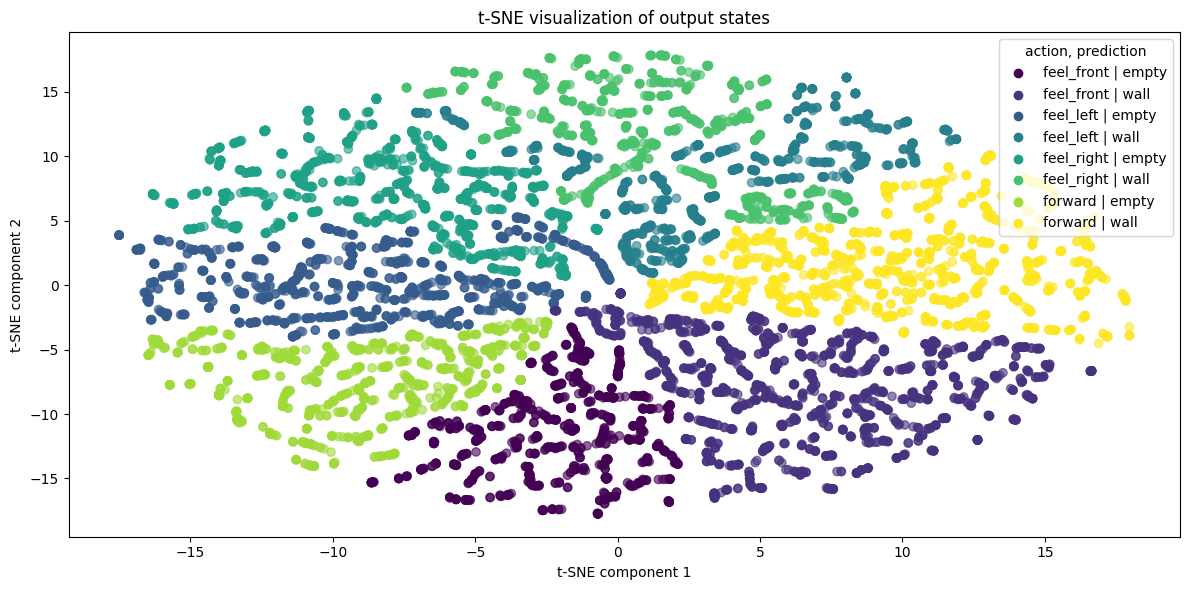

/tmp/ipykernel_20214/2060518303.py:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_colors, cmap='viridis', alpha=0.6)


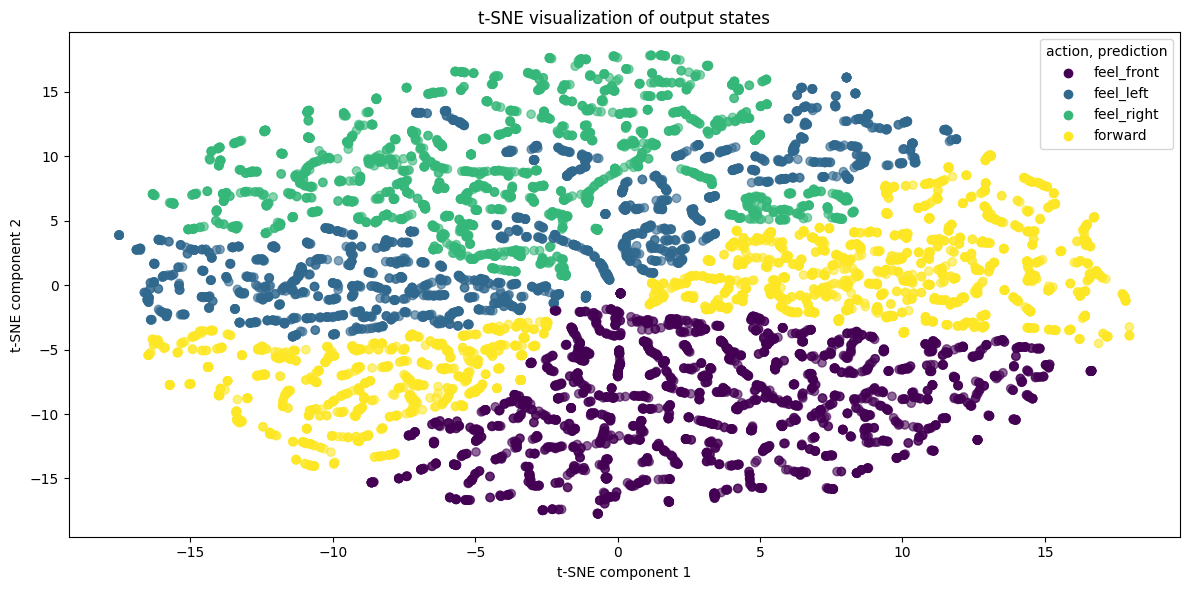

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_output_stack = torch.stack(all_output_1)

all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_output_stack = all_output_stack.detach().cpu().numpy()

all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)
all_output_emb = tsne.fit_transform(all_output_stack)

front_info = [str(info) for info in data_infos_success["state_front"]]
left_info = [str(info) for info in data_infos_success["state_left"]]
right_info = [str(info) for info in data_infos_success["state_right"]]

act_pred = [str(eval(to_act)[-2]) + ' | ' +  pred for to_act, pred in zip(data_infos_success["seq_dec"], data_infos_success["prediction_dec"])]
act = [str(eval(to_act)[-2]) for to_act in data_infos_success["seq_dec"]]

print("act_pred", act_pred)

unique_front = np.unique(front_info)
unique_left = np.unique(left_info)
unique_right = np.unique(right_info)
unique_act_pred = np.unique(act_pred)
unique_act = np.unique(act)

color_map_front = plt.cm.get_cmap('viridis', len(unique_front))
front_colors = [color_map_front(unique_front.tolist().index(str(feel))) for feel in front_info]

color_map_left = plt.cm.get_cmap('viridis', len(unique_left))
left_colors = [color_map_left(unique_left.tolist().index(str(feel))) for feel in left_info]

color_map_right = plt.cm.get_cmap('viridis', len(unique_feel))
right_colors = [color_map_right(unique_right.tolist().index(str(feel))) for feel in right_info]

color_map_act_pred = plt.cm.get_cmap('viridis', len(unique_act_pred))
act_pred_colors = [color_map_act_pred(unique_act_pred.tolist().index(_act)) for _act in act_pred]

color_map_act = plt.cm.get_cmap('viridis', len(unique_act))
act_colors = [color_map_act(unique_act.tolist().index(_act)) for _act in act]

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_pred_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act_pred, color_map_act_pred(np.arange(len(unique_act_pred)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=act_colors, cmap='viridis', alpha=0.6)
plt.title('t-SNE visualization of output states')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
# Ajouter une légende pour les couleurs
for coo, color in zip(unique_act, color_map_act(np.arange(len(unique_act)))):
    plt.scatter([], [], c=[color], label=f'{coo}')
plt.legend(title='action, prediction')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=front_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_feel, color_map_front(np.arange(len(unique_feel)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, front')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=left_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_left, color_map_left(np.arange(len(unique_left)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, left')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.scatter(all_output_emb[:, 0], all_output_emb[:, 1], c=right_colors, cmap='viridis', alpha=0.6)
# plt.title('t-SNE visualization of output states')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# # Ajouter une légende pour les couleurs
# for coo, color in zip(unique_right, color_map_right(np.arange(len(unique_right)))):
#     plt.scatter([], [], c=[color], label=f'fb {coo}')
# plt.legend(title='feedback, right')
# plt.tight_layout()
# plt.show()

# tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)
# all_output_emb = tsne.fit_transform(all_output_stack)

# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(121, projection='3d')
# sc1 = ax1.scatter(all_output_emb[:, 0], all_output_emb[:, 1], all_output_emb[:, 2], c=front_colors, cmap='viridis', alpha=0.6)
# ax1.set_title('t-SNE visualization of output states (all_output)')
# ax1.set_xlabel('t-SNE component 1')
# ax1.set_ylabel('t-SNE component 2')
# ax1.set_zlabel('t-SNE component 3')


/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_20214/336493527.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_feel))
/tmp/ipykernel_20214/336493527.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridi

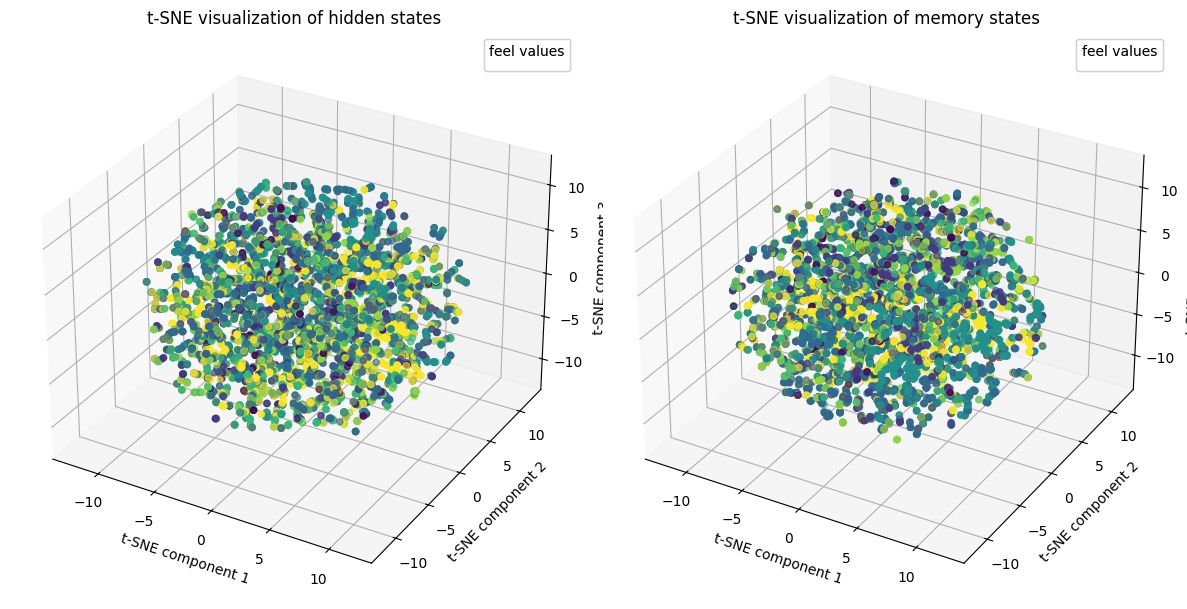

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_20214/336493527.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
/tmp/ipykernel_20214/336493527.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
/home/pe/Documents/stage/Dpt_transfo

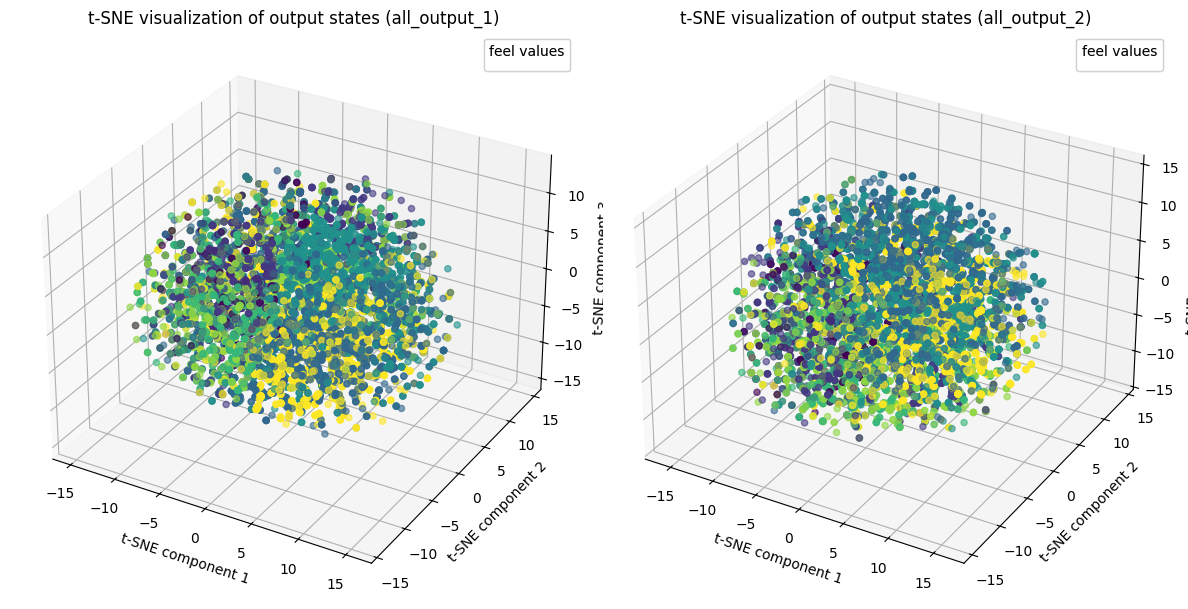

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Ajuster TSNE pour générer trois composants
tsne = TSNE(n_components=3, random_state=42, perplexity=5, n_iter=300)

# Transformer les données en embeddings 3D
all_hidden_stack = torch.stack(all_hidden)
all_mem_stack = torch.stack(all_mem)
all_hidden_stack = all_hidden_stack.detach().cpu().numpy()
all_mem_stack = all_mem_stack.detach().cpu().numpy()
all_hidden_emb = tsne.fit_transform(all_hidden_stack)
all_mem_emb = tsne.fit_transform(all_mem_stack)

# Extraire les informations "feel" de data_infos

feel_info = [str(info[0]) + str(info[1]) + str(info[2]) for info in zip(data_infos_success["state_left"], data_infos_success["state_front"], data_infos_success["state_right"])]
unique_feel = np.unique(feel_info)
color_map = plt.cm.get_cmap('viridis', len(unique_feel))
feel_colors = [color_map(unique_feel.tolist().index(str(feel))) for feel in feel_info]

# Créer les scatter plots 3D pour les embeddings
fig = plt.figure(figsize=(12, 6))

# Plot pour all_hidden_emb
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_hidden_emb[:, 0], all_hidden_emb[:, 1], all_hidden_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of hidden states')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_mem_emb
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_mem_emb[:, 0], all_mem_emb[:, 1], all_mem_emb[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of memory states')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

# Pour les sorties all_output_1 et all_output_2
tsne = TSNE(n_components=3, random_state=42, perplexity=2, n_iter=300)

all_output_stack_1 = torch.stack(all_output_1)
all_output_stack_1 = all_output_stack_1.detach().cpu().numpy()
all_output_emb_1 = tsne.fit_transform(all_output_stack_1)

all_output_stack_2 = torch.stack(all_output_2)
all_output_stack_2 = all_output_stack_2.detach().cpu().numpy()
all_output_emb_2 = tsne.fit_transform(all_output_stack_2)

fig = plt.figure(figsize=(12, 6))

# Plot pour all_output_emb_1
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(all_output_emb_1[:, 0], all_output_emb_1[:, 1], all_output_emb_1[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE visualization of output states (all_output_1)')
ax1.set_xlabel('t-SNE component 1')
ax1.set_ylabel('t-SNE component 2')
ax1.set_zlabel('t-SNE component 3')

# Plot pour all_output_emb_2
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(all_output_emb_2[:, 0], all_output_emb_2[:, 1], all_output_emb_2[:, 2], c=feel_colors, cmap='viridis', alpha=0.6)
ax2.set_title('t-SNE visualization of output states (all_output_2)')
ax2.set_xlabel('t-SNE component 1')
ax2.set_ylabel('t-SNE component 2')
ax2.set_zlabel('t-SNE component 3')

# Ajouter une légende pour les couleurs
legend1 = ax1.legend(*sc1.legend_elements(), title="feel values")
ax1.add_artist(legend1)
legend2 = ax2.legend(*sc2.legend_elements(), title="feel values")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()


In [ ]:
raise "end"

TypeError: exceptions must derive from BaseException

# Not implemented

In [ ]:
input_seq = torch.tensor(tokenizer.encode(
    ['forward', 'empty', 'feel_right', 'empty', 'turn_left', 'empty', 'feel_front', 'empty', 'feel_front', 'empty', 'forward', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_left', 'empty', 'feel_front', 'wall', 'forward', 'wall', 'turn_right', 'empty', 'turn_right', '<pad>']
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['forward', 'empty'] * 4
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))
1000
# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq[-2] = 'feel_front'
list_seq[-1] = 'wall'
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
# Repeat 'forward', 'empty', * 5
list_seq = ['feel_left', 'wall', 'turn_right', 'empty', 'turn_right', 'empty', 'turn_right', 'empty', 'feel_front', 'empty']
print("list_seq", list_seq)

input_seq = torch.tensor(tokenizer.encode(
  list_seq
))

# Initialiser les états cachés et de la cellule
hidden_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)
mem_in = torch.zeros(model_fb.num_layers * 2, 1, model_fb.hidden_size)

# Passer la séquence à travers le LSTM
output, (hidden_out, mem_out) = model_fb.lstm(model_fb.embedding(input_seq))

# Extraire les états cachés pour chaque pas de temps
# Note: output contient les états cachés pour chaque pas de temps
hidden_states = output.squeeze(1).detach().numpy()

# Appliquer t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=300)
hidden_states_2d = tsne.fit_transform(hidden_states)

# Visualiser les résultats
plt.figure(figsize=(12, 8))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], c=np.arange(hidden_states_2d.shape[0]), cmap='viridis')
plt.colorbar(label='Time Step')
plt.title('t-SNE Visualization of LSTM Hidden States Over Time')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Avec interaction

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


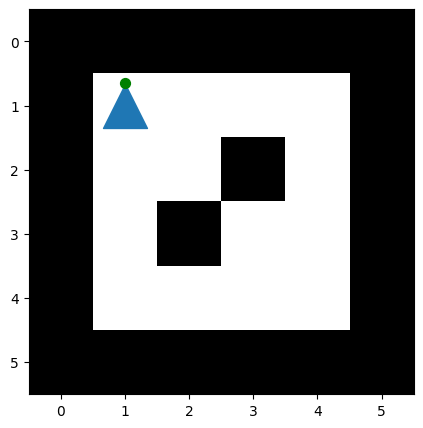

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_interaction.display_world()

In [ ]:
list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)
for key, value in tokenizer_interaction.str_to_int.items():
    print(f"{key}: {value}")

<pad>: 0
<mask>: 1
('forward', 'wall'): 2
('forward', 'empty'): 3
('turn_left', 'wall'): 4
('turn_left', 'empty'): 5
('turn_right', 'wall'): 6
('turn_right', 'empty'): 7
('feel_front', 'wall'): 8
('feel_front', 'empty'): 9
('feel_left', 'wall'): 10
('feel_left', 'empty'): 11
('feel_right', 'wall'): 12
('feel_right', 'empty'): 13
forward: 14
turn_left: 15
turn_right: 16
feel_front: 17
feel_left: 18
feel_right: 19
wall: 20
empty: 21


In [ ]:
def get_data_interaction(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

In [ ]:
data_train_inter = []
for i in range(10):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=5))
print("data_train_inter", data_train_inter)
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))

data_train_inter [[2, 10, 10, 8, 10], [8, 7, 5, 13, 10], [10, 10, 13, 8, 5], [7, 2, 8, 10, 10], [10, 5, 2, 8, 8], [2, 12, 2, 11, 5], [5, 9, 10, 10, 7], [7, 7, 13, 10, 5], [8, 2, 5, 3, 7], [7, 7, 9, 11, 11]]
[('forward', 'wall'), ('feel_left', 'wall'), ('feel_left', 'wall'), ('feel_front', 'wall'), ('feel_left', 'wall')]
[('feel_front', 'wall'), ('turn_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('feel_left', 'wall')]
[('feel_left', 'wall'), ('feel_left', 'wall'), ('feel_right', 'empty'), ('feel_front', 'wall'), ('turn_left', 'empty')]
[('turn_right', 'empty'), ('forward', 'wall'), ('feel_front', 'wall'), ('feel_left', 'wall'), ('feel_left', 'wall')]
[('feel_left', 'wall'), ('turn_left', 'empty'), ('forward', 'wall'), ('feel_front', 'wall'), ('feel_front', 'wall')]
[('forward', 'wall'), ('feel_right', 'wall'), ('forward', 'wall'), ('feel_left', 'empty'), ('turn_left', 'empty')]
[('turn_left', 'empty'), ('feel_front', 'empty'), ('feel_left', 'wall'), ('feel_left', 

In [ ]:
class TokenDropInteraction(nn.Module):
    """For a batch of tokens indices, randomly replace a interaction token with action associated to it.
    """

    def __init__(self, tokenizer, prob=0.1, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.dic_remplacement = {}
        for key, value in tokenizer.str_to_int.items():
            if type(key) == tuple:
                self.dic_remplacement[value] = tokenizer.encode(key[0])
                
    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        for interaction, replacement in self.dic_remplacement.items():
            interaction_mask = (sample == interaction) & (mask == 1)
            sample = torch.where(interaction_mask, replacement, sample)
        
        return sample, mask

In [ ]:
td = TokenDropInteraction(tokenizer=tokenizer_interaction, prob=0.5, num_special=2)

data_train_inter[0][-1] = 0
data_target_inter, mask = td(torch.tensor(data_train_inter))
for seq in data_train_inter:
    print(tokenizer_interaction.decode(seq))
    
print("version masker")
for seq in data_target_inter.tolist():
    print(tokenizer_interaction.decode(seq))

[('forward', 'wall'), ('feel_left', 'wall'), ('feel_left', 'wall'), ('feel_front', 'wall'), '<pad>']
[('feel_front', 'wall'), ('turn_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('feel_left', 'wall')]
[('feel_left', 'wall'), ('feel_left', 'wall'), ('feel_right', 'empty'), ('feel_front', 'wall'), ('turn_left', 'empty')]
[('turn_right', 'empty'), ('forward', 'wall'), ('feel_front', 'wall'), ('feel_left', 'wall'), ('feel_left', 'wall')]
[('feel_left', 'wall'), ('turn_left', 'empty'), ('forward', 'wall'), ('feel_front', 'wall'), ('feel_front', 'wall')]
[('forward', 'wall'), ('feel_right', 'wall'), ('forward', 'wall'), ('feel_left', 'empty'), ('turn_left', 'empty')]
[('turn_left', 'empty'), ('feel_front', 'empty'), ('feel_left', 'wall'), ('feel_left', 'wall'), ('turn_right', 'empty')]
[('turn_right', 'empty'), ('turn_right', 'empty'), ('feel_right', 'empty'), ('feel_left', 'wall'), ('turn_left', 'empty')]
[('feel_front', 'wall'), ('forward', 'wall'), ('turn_left', 'emp

In [ ]:
data_set_interaction = SimpleDataSet(data_train_inter)

tensor([[ 2, 10, 10,  8,  0],
        [ 8,  7,  5, 13, 10],
        [10, 10, 13,  8,  5],
        [ 7,  2,  8, 10, 10],
        [10,  5,  2,  8,  8],
        [ 2, 12,  2, 11,  5],
        [ 5,  9, 10, 10,  7],
        [ 7,  7, 13, 10,  5],
        [ 8,  2,  5,  3,  7],
        [ 7,  7,  9, 11, 11]])


In [ ]:
def eval_inter(model, data_loader, tokenizer):
    acc = 0
    data_frame_seq_inter = pd.DataFrame({
        "seq": [""] * len(data_loader),
        "seq_dec": [""] * len(data_loader),
        "prediction": [""] * len(data_loader),
        "prediction_dec": [""] * len(data_loader),
        "reality": [""] * len(data_loader),
        "reality_dec": [""] * len(data_loader),
        "probability": [""] * len(data_loader),
        "good_prediction": [False] * len(data_loader),
        "info_in_seq": [False] * len(data_loader),
        "info_feel_left": [False] * len(data_loader),
        "info_feel_front": [False] * len(data_loader),
        "info_feel_right": [False] * len(data_loader),
        "coo_xy": [""] * len(data_loader),
        "theta": [-1] * len(data_loader),
        "state_left": [""] * len(data_loader),
        "state_front": [""] * len(data_loader),
        "state_right": [""] * len(data_loader)
    })

    with torch.no_grad():
        h = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        cell = torch.zeros(model.num_layers * 2, 1, model.hidden_size).to(device)
        for i, (input, target, info) in tqdm(enumerate(data_loader)):
            input = input.to(device)
            target = target.to(device)
            
            output, _, _ = model(input, h, cell)
            
            arrays, x, y, theta = process_sequence_inter(tokenizer.decode(input.tolist()[0]), 6, None)
            good_seq = info_in_memory(arrays)
            feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
            
            proba = F.softmax(output, dim=-1)
            output = output.transpose(1, 2)
            pred = output.argmax(dim=1)
            acc += (pred[-1][-1] == target).item()
            state_left = info["feel_left"][0]
            state_front = info["feel_front"][0]
            state_right = info["feel_right"][0]
            coo = (info["coo"][0].item(), info["coo"][1].item())
            theta = info["theta"][0].item()

            data_frame_seq_inter.loc[i] = [
                str(input.tolist()[0]),
                str(tokenizer.decode(input.tolist()[0])),
                str(pred.tolist()[0][-1]),
                str(tokenizer.decode(pred.tolist()[0][-1])),
                str(target.tolist()[0]),
                str(tokenizer.decode(target.tolist()[0])),
                str(proba.tolist()[-1][-1][-2:]),
                (pred[-1][-1] == target).item(),
                good_seq,
                feel_left,
                feel_front,
                feel_right,
                str(coo),
                theta,
                state_left,
                state_front,
                state_right
            ]
    
    return acc, data_frame_seq_inter

0it [00:00, ?it/s]

Accuracy: 0.5861


In [ ]:
def train_inter(model: nn.Module, 
            data_loader_train: DataLoader, data_loader_validation: DataLoader,
            nb_epoch: int, tokenizer:SimpleTokenizerV1,
            optimizer, loss_fn, pourcentTokenDrop:float=0.15):
    td = TokenDropInteraction(
        prob=pourcentTokenDrop,
        tokenizer=tokenizer,
        num_special=2)

    model.train()
    list_acc = []
    list_validation = []
    list_loss = []
    for epoch in tqdm(range(nb_epoch), desc=f"Training ", unit="epoch"):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data_mask, mask = td(data)
            # print("data_mask", data_mask)
            # for seq in data_mask.tolist():
            #     print(tokenizer_interaction.decode(seq))
            bs = data.shape[0]

            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size).to(device)
            
            data_mask = data_mask.to(device)
            data = data.to(device)
                        
            proba, hidden, memory = model(data_mask, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (mask == 0)
            
            pad_mask = pad_mask.to(device)
            pred = pred.to(device)
            mask = mask.to(device)
            # pred_in_seq = pred * pad_mask + 0 * mask
            
            # Mettre <pad> pour les tokens non masqués
            # pred_in_seq = pred_in_seq.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("proba", proba.shape)
            # print("pad_mask", pad_mask.shape)
            # pad_mask pass shape [bs, context_size] to [bs, num_emb ,context_size]
            # pad_mask = pad_mask.unsqueeze(1).expand(-1, proba.shape[1], -1)
            # print("pad_mask", pad_mask.shape)
            # prob_without_mask = proba.masked_fill(pad_mask, tokenizer.encode("<pad>"))
            # print("prob_without_mask", prob_without_mask)
            
            correct = (pred == data)
            # print("pred", pred)
            # for seq in pred.tolist():
            #     print(tokenizer_interaction.decode(seq))
            # print("data", data)
            # for seq in data.tolist():
            #     print(tokenizer_interaction.decode(seq))

            
            acc = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc2 = correct.sum() / (correct.shape[0] * correct.shape[1])
            # acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        acc_val, _ = eval_inter(model, data_loader_validation, tokenizer)
        acc_val = acc_val / len(data_loader_validation)
        list_validation.append(acc_val)
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        tqdm.write(f"Epoch {epoch + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
        
    return list_acc, list_loss, list_validation

In [ ]:
env_interaction = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

list_vocab = ['<pad>', '<mask>']
for act in env_interaction.get_actions():
    for fb in env_interaction.get_outcomes():
        list_vocab.append((act, fb))
for act in env_interaction.get_actions():
    list_vocab.append(act)
for fb in env_interaction.get_outcomes():
        list_vocab.append(fb)
tmp = create_dico_numerate_word(list_vocab)
tokenizer_interaction = SimpleTokenizerV1(vocab=tmp)

dic_remplacement = {}
for key, value in tokenizer_interaction.str_to_int.items():
    if type(key) == tuple:
        dic_remplacement[value] = tokenizer_interaction.encode(key[0])

data_train_inter = []
for i in range(10000):
    data_train_inter.append(get_data_interaction(env_interaction, tokenizer_interaction, n_episodes=50))
data_set_interaction = SimpleDataSet(data_train_inter)
data_loader_interaction = DataLoader(data_set_interaction, batch_size=16, shuffle=True)

hidden_size = 32
num_layers = 1
model_inter = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.15
)

model_inter.to(device)

optimizer_inter = optim.Adam(model_inter.parameters(), lr=0.001)
loss_fn_inter = nn.CrossEntropyLoss(ignore_index=tokenizer_interaction.encode("<pad>"))

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
tensor([[ 2,  8, 10,  ...,  2,  7,  5],
        [13,  5, 11,  ...,  9, 12, 12],
        [ 5,  5,  5,  ...,  8, 11, 13],
        ...,
        [ 2, 12,  8,  ..., 13,  7,  3],
        [11,  9,  9,  ...,  7, 13,  5],
        [ 2, 11,  7,  ...,  3,  5,  2]])


In [ ]:
list_acc, list_loss, list_val = train_inter(
    model=model_inter,
    data_loader_train=data_loader_interaction, data_loader_validation=data_loader_test_inter,
    nb_epoch=20,
    tokenizer=tokenizer_interaction,
    optimizer=optimizer_inter,
    loss_fn=loss_fn_inter,
    pourcentTokenDrop=0.15
)

Training :   0%|          | 0/20 [00:00<?, ?epoch/s]

0it [00:00, ?it/s]

Epoch 1/20, Loss: 0.060100940987467766, Accuracy: 0.9831249713897705


0it [00:00, ?it/s]

Epoch 2/20, Loss: 0.058434453792870045, Accuracy: 0.9818750023841858


0it [00:00, ?it/s]

Epoch 3/20, Loss: 0.07445300556719303, Accuracy: 0.96812504529953


0it [00:00, ?it/s]

Epoch 4/20, Loss: 0.06208611652255058, Accuracy: 0.9774999618530273


0it [00:00, ?it/s]

Epoch 5/20, Loss: 0.04777429671958089, Accuracy: 0.9853124618530273


0it [00:00, ?it/s]

Epoch 6/20, Loss: 0.05660033877938986, Accuracy: 0.9749999642372131


0it [00:00, ?it/s]

Epoch 7/20, Loss: 0.06385557260364294, Accuracy: 0.973437488079071


0it [00:00, ?it/s]

Epoch 8/20, Loss: 0.056405290961265564, Accuracy: 0.97718745470047


0it [00:00, ?it/s]

Epoch 9/20, Loss: 0.04212242388166487, Accuracy: 0.9853124618530273


0it [00:00, ?it/s]

Epoch 10/20, Loss: 0.05063083115965128, Accuracy: 0.9834374785423279


0it [00:00, ?it/s]

Epoch 11/20, Loss: 0.049420831725001335, Accuracy: 0.981874942779541


0it [00:00, ?it/s]

Epoch 12/20, Loss: 0.05346687976270914, Accuracy: 0.9790624976158142


0it [00:00, ?it/s]

Epoch 13/20, Loss: 0.06177725829184055, Accuracy: 0.9728124737739563


0it [00:00, ?it/s]

Epoch 14/20, Loss: 0.05144902691245079, Accuracy: 0.9853124618530273


0it [00:00, ?it/s]

Epoch 15/20, Loss: 0.051491010934114456, Accuracy: 0.9840624332427979


0it [00:00, ?it/s]

Epoch 16/20, Loss: 0.05749165080487728, Accuracy: 0.9790624976158142


0it [00:00, ?it/s]

Epoch 17/20, Loss: 0.0583667503669858, Accuracy: 0.9762499928474426


0it [00:00, ?it/s]

Epoch 18/20, Loss: 0.04653600882738829, Accuracy: 0.9837499856948853


0it [00:00, ?it/s]

Epoch 19/20, Loss: 0.04755990672856569, Accuracy: 0.9840624332427979


0it [00:00, ?it/s]

Epoch 20/20, Loss: 0.05686264764517546, Accuracy: 0.9768750071525574


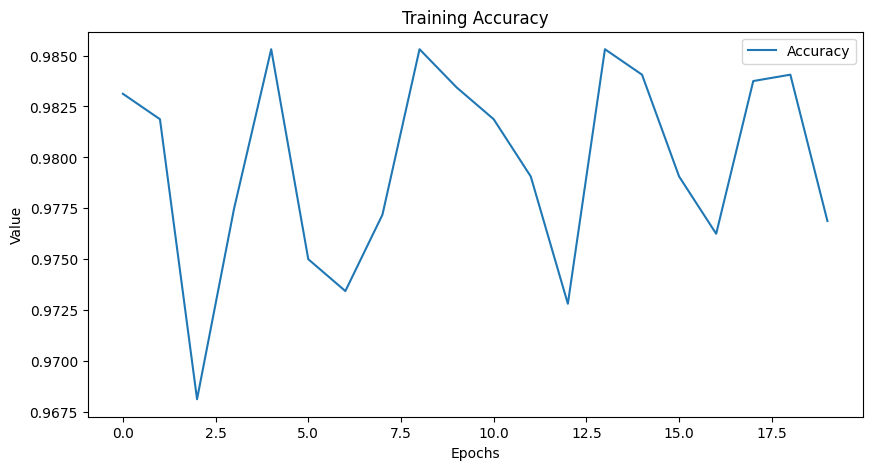

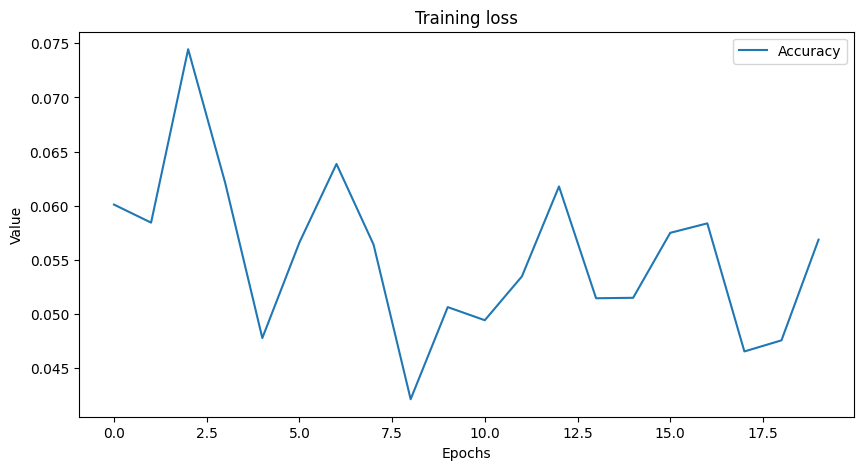

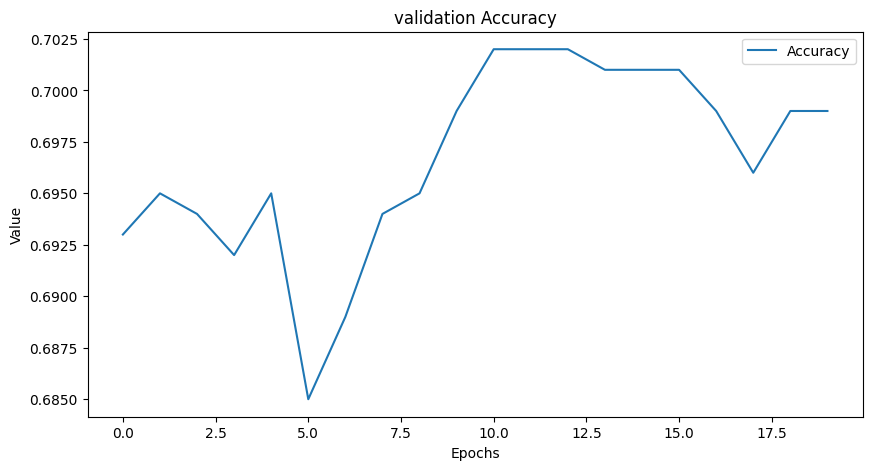

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
list_acc = torch.tensor(list_acc).cpu()
plt.plot(list_acc, label='Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(list_loss, label='Accuracy')
plt.title('Training loss')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(10, 5))
# plt.plot(list_loss, label='Loss')
plt.plot(list_val, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('validation Accuracy')
plt.legend()
plt.show()

In [ ]:
env_test_inter = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 1, 0, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

data_test_x_inter = []
data_test_y_inter = []
data_infos_inter = []
for i in range(1000):
    # range_context = np.random.randint(10, 20)
    range_context = 20
    last_inter =  ('turn_right', 'empty')
    while last_inter ==  ('turn_right', 'empty') or last_inter ==  ('turn_left', 'empty'):
        sequence = get_data_interaction(env_test_inter, tokenizer_interaction, n_episodes=range_context)
        last_inter = tokenizer_interaction.decode(sequence[-1])
        
    # print("last_inter", last_inter)
    # print("sequence", tokenizer_interaction.decode(sequence))
    
           
    data_test_y_inter.append(sequence[-1])
    data_test_x_inter.append(sequence[:-1] + [dic_remplacement[sequence[-1]]])
    
    # print("data_test_x", data_test_x_inter)
    # print("data_test_x", tokenizer_interaction.decode(data_test_x_inter[-1]))

    
    data_infos_inter.append({
        "sequence": sequence,
        "coo": env_test_inter.get_coo(),
        "theta": env_test_inter.get_theta(),
        "last_inter": last_inter,
        "info_in_sequence": bool(info_in_seq(tokenizer_interaction.decode(data_test_x_inter[-1]), 6))
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test_inter.outcome(feel)
        data_infos_inter[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y_inter:
    if i == 8:
        count_8 += 1
    elif i == 9:
        count_7 += 1
print(f"count_8 {tokenizer_interaction.decode(8)}", count_8)
print(f"count_7 {tokenizer_interaction.decode(9)}", count_7)

print("data_infos", data_infos_inter[0])
print("x ", data_test_x_inter[0])
print("y ", data_test_y_inter[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 ('feel_front', 'wall') 140
count_7 ('feel_front', 'empty') 115
data_infos {'sequence': [7, 10, 3, 12, 11, 12, 11, 12, 12, 7, 7, 13, 5, 8, 5, 5, 13, 3, 13, 2], 'coo': (3, 3), 'theta': 0, 'last_inter': ('forward', 'wall'), 'info_in_sequence': False, 'feel_front': 'wall', 'feel_left': 'wall', 'feel_right': 'empty'}
x  [7, 10, 3, 12, 11, 12, 11, 12, 12, 7, 7, 13, 5, 8, 5, 5, 13, 3, 13, 14]
y  2


In [ ]:
class CustomDataSetInfo(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

In [ ]:
length = max(len(xi) for xi in data_test_x_inter)
data_test_x_tensor_inter = torch.zeros((len(data_test_x_inter), length), dtype=torch.long)
for i, xi in enumerate(data_test_x_inter):
    data_test_x_tensor_inter[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor_inter = torch.tensor(data_test_y_inter, dtype=torch.long)

data_loader_test_inter = DataLoader(CustomDataSetInfo(data_test_x_tensor_inter, data_test_y_tensor_inter, data_infos_inter), batch_size=1, shuffle=False)

for i, (data_x, data_y, info) in enumerate(data_loader_test_inter):
    print(data_x)
    print(data_y)
    for key, value in info.items():
        print(f"{key}: {value}")
    break

tensor([[ 7, 10,  3, 12, 11, 12, 11, 12, 12,  7,  7, 13,  5,  8,  5,  5, 13,  3,
         13, 14]])
tensor([2])
sequence: [tensor([7]), tensor([10]), tensor([3]), tensor([12]), tensor([11]), tensor([12]), tensor([11]), tensor([12]), tensor([12]), tensor([7]), tensor([7]), tensor([13]), tensor([5]), tensor([8]), tensor([5]), tensor([5]), tensor([13]), tensor([3]), tensor([13]), tensor([2])]
coo: [tensor([3]), tensor([3])]
theta: tensor([0])
last_inter: [('forward',), ('wall',)]
info_in_sequence: tensor([False])
feel_front: ['wall']
feel_left: ['wall']
feel_right: ['empty']


In [ ]:
acc, data_frame_seq_inter = eval_inter(model_inter, data_loader_test_inter, tokenizer_interaction)
print(f"Accuracy: {acc / 1000}")

0it [00:00, ?it/s]

Accuracy: 0.699
